In [2]:
!wget --no-check-certificate --content-disposition https://github.com/AccentDB/one-speaker-vectors/archive/master.zip
!unzip one-speaker-vectors-master.zip

--2023-01-25 18:02:37--  https://github.com/AccentDB/one-speaker-vectors/archive/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/AccentDB/one-speaker-vectors/zip/refs/heads/master [following]
--2023-01-25 18:02:37--  https://codeload.github.com/AccentDB/one-speaker-vectors/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'one-speaker-vectors-master.zip.1'

p.1                     [     <=>            ]  13.60M  2.39MB/s               ^C
Archive:  one-speaker-vectors-master.zip
913a639d20572f0e230b27c41831b302c4e5fddc
replace one-speaker-vectors-master/american_speaker_01.files.npy? [y]es, [n]o, 

In [20]:
# My objective of this project is to train a model to classify a variety of English-speaking accents. 
# The dataset consists of 9 accent category 3-dimensional NumPy arrays - each containing N 'audioclip' samples. Each sample has
# 499 data points each with 13 Mel-Frequency Cepstral Coefficient (MFCC) feature vectors which have been extracted
# during a pre-processing stage. The shape of these vectors is therefore (N, 499, 13). 

#1) Normalise the MFCC feature vectors to enable faster gradient descent.

#2) Compile the data into a single array, X and a Sparse Categorically labelled array, Y (i.e 0,1,2,3,4,5,6,7,8).

#3) Split these data into X_train, X_cv, X_test sets and correspondingly, Y_train, Y_cv, X_test

#4) Build model using a series of Conv1D, MaxPooling, Dense, Dropout, and Flatten layers. Dropout layers are a method of
#   of regularisation.

#5) Train model. Use J_cv and J_train to evaluate bias and variance and adjust hyperparameters, batch_size and epoch_number accordingly.

#6) Make predictions and evaluate the model using the X_test set. Generate statistics for misclassification.

# from __future__ import print_function
import numpy as np
import datetime, os, random
import tensorflow as tf
import seaborn as sns
from time import time
import np_utils

# Scikit imports for data handling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


#Tensorflow imports
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Convolution1D, MaxPooling1D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import warnings
warnings.filterwarnings('ignore')

# for reproducibility
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed) 
random.seed(1)
tf.random.set_seed(seed)

# Load tensorboard and check Tensorfow version
%reload_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(tf.__version__)

2.10.0


In [21]:
def normalize(v):
  # Suppose your vector is v:
  # 1. First convert it to 2 dimensional for intuitive manipulation
  x = v.shape[1]
  y = v.shape[2]
  v = v.reshape((-1, x * y))
  # 2. Compute norm
  nm = np.linalg.norm(v, axis=1)
  # 3. Reshape it so it can be divided
  nm = nm.reshape((-1,1))
  # 4. Divide
  v = v/nm
  # 5. Get the matrix back
  v = v.reshape((-1, x, y))
  return v
  
print('Loading data...')

bangla = normalize(np.load("one-speaker-vectors-master/bangla_speaker_01.files.npy"))
malayalam = normalize(np.load("one-speaker-vectors-master/malayalam_speaker_01.files.npy"))
odiya = normalize(np.load("one-speaker-vectors-master/odiya_speaker_01.files.npy"))
telugu = normalize(np.load("one-speaker-vectors-master/telugu_speaker_01.files.npy"))
indian = normalize(np.load("one-speaker-vectors-master/indian_speaker_01.files.npy"))
australian = normalize(np.load("one-speaker-vectors-master/australian_speaker_01.files.npy"))
british = normalize(np.load("one-speaker-vectors-master/british_speaker_01.files.npy"))
american = normalize(np.load("one-speaker-vectors-master/american_speaker_01.files.npy"))
welsh = normalize(np.load("one-speaker-vectors-master/welsh_speaker_01.files.npy"))

print(bangla.shape)
print(bangla[0,0,:])

Loading data...
(778, 499, 13)
[-0.00468202 -0.00435702 -0.00430347 -0.00429988 -0.00446875 -0.00440902
 -0.0045635  -0.00450529 -0.00446401 -0.00437817 -0.0042765  -0.00432201
 -0.00449182]


In [16]:
# Define categories
'''samples = {
  "bangla": bangla,
  "malayalam": malayalam,
  "odiya": odiya,
  "telugu": telugu,
  "indian": indian,
  "australian": australian,
  "british": british,
  "american": american,
  "welsh": welsh,

}

indian = ["bangla", "malayalam", "odiya", "telugu"]
non_indian = ["australian", "british", "american", "welsh"]
all_accents = indian + non_indian + ["indian"]
print("Indian accents: ", indian)
print("Non-Indian accents: ", non_indian)
print("All accents: ", all_accents)
'''

'samples = {\n  "bangla": bangla,\n  "malayalam": malayalam,\n  "odiya": odiya,\n  "telugu": telugu,\n  "indian": indian,\n  "australian": australian,\n  "british": british,\n  "american": american,\n  "welsh": welsh,\n\n}\n\nindian = ["bangla", "malayalam", "odiya", "telugu"]\nnon_indian = ["australian", "british", "american", "welsh"]\nall_accents = indian + non_indian + ["indian"]\nprint("Indian accents: ", indian)\nprint("Non-Indian accents: ", non_indian)\nprint("All accents: ", all_accents)\n'

In [22]:
#stack all numpy arrays into a single X_ vector with a corresponding Y_ vector

accents = [bangla, malayalam, odiya, telugu, indian, australian, british, american, welsh]
X = np.concatenate(accents, axis=0)

Y = np.concatenate((bangla.shape[0]*[0], malayalam.shape[0]*[1], odiya.shape[0]*[2], telugu.shape[0]*[3], 
                   indian.shape[0]*[4], australian.shape[0]*[5], british.shape[0]*[6], american.shape[0]*[7], 
                   welsh.shape[0]*[8]))

print(bangla.shape[0])
print(X.shape)
print(Y)

778
(6752, 499, 13)
[0 0 0 ... 8 8 8]


In [26]:
#split into train, cv, test

X_train, X_, Y_train, Y_ = train_test_split(X,Y,test_size=0.4, random_state=1)

#print(X_train[3])
#print(Y_train[3])

X_cv, X_test, Y_cv, Y_test = train_test_split(X_,Y_,test_size=0.5, random_state=1)

print("X_train.shape", X_train.shape, "Y_train.shape", Y_train.shape)
print("X_cv.shape", X_cv.shape, "Y_cv.shape", Y_cv.shape)
print("X_test.shape", X_test.shape, "Y_test.shape", Y_test.shape)

X_train.shape (4051, 499, 13) Y_train.shape (4051,)
X_cv.shape (1350, 499, 13) Y_cv.shape (1350,)
X_test.shape (1351, 499, 13) Y_test.shape (1351,)


In [43]:
# 499 dimensions are produced by sampling a 5s audio file at 1ms
test_dim = 499
# we use 13 MFCC features in our work
input_shape = (test_dim, 13)

tf.random.set_seed(1234)

model = Sequential(
[
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation='linear')
]
)


model.compile(
loss=SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'],
optimizer=tf.keras.optimizers.Adam(lr=0.01)
)
    

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 497, 32)           1280      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 496, 32)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 494, 32)           3104      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 493, 32)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 491, 64)           6208      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 490, 64)        

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 20
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True,patience=10)

start = datetime.now()

history = model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_cv, Y_cv), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
125/127 [============================>.] - ETA: 0s - loss: 0.6173 - accuracy: 0.7632
Epoch 1: val_loss improved from inf to 0.12952, saving model to saved_models/audio_classification.hdf5
127/127 [==============================] - 3s 23ms/step - loss: 0.6137 - accuracy: 0.7645 - val_loss: 0.1295 - val_accuracy: 0.9644
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9143
Epoch 2: val_loss did not improve from 0.12952
127/127 [==============================] - 3s 22ms/step - loss: 0.2467 - accuracy: 0.9143 - val_loss: 0.1357 - val_accuracy: 0.9585
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9383
Epoch 3: val_loss improved from 0.12952 to 0.06781, saving model to saved_models/audio_classification.hdf5
127/127 [==============================] - 3s 23ms/step - loss: 0.1818 - accuracy: 0.9383 - val_loss: 0.0678 - val_accuracy: 0.9763
Epoch 4/20
127/127 [==============================] - ETA: 

In [45]:
model.evaluate(X_train, Y_train)
model.evaluate(X_cv, Y_cv)
model.evaluate(X_test, Y_test)

43/43 [==============================] - 0s 6ms/step - loss: 0.0752 - accuracy: 0.9822


[0.07517834007740021, 0.9822353720664978]

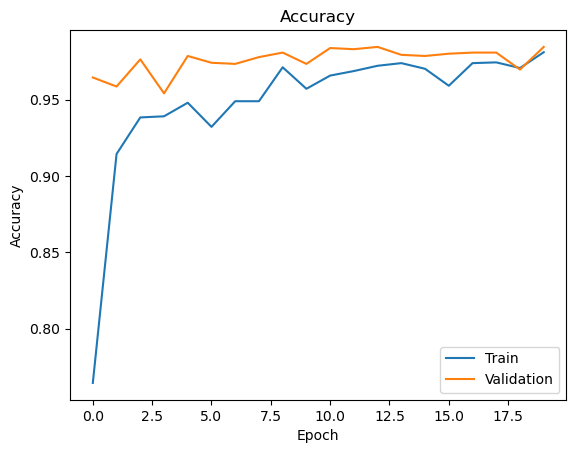

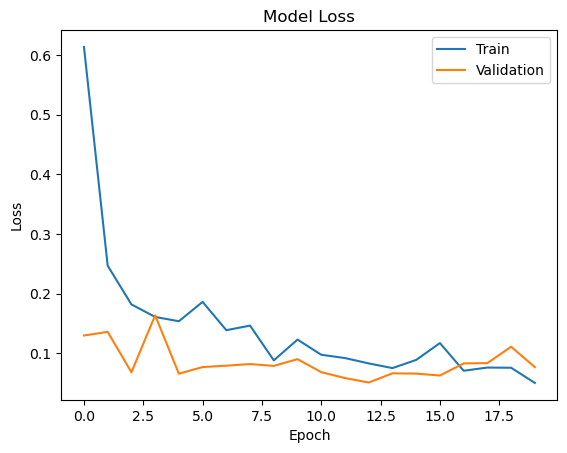

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'lower right')
plt.show()

# Plot training and validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()


In [47]:
# Get the prediction from the X_test Dataset
prediction_ANN = model.predict(X_test)
prediction_ANN_rounded = [np.argmax(i) for i in prediction_ANN]
prediction_ANN_rounded[0]
y_test_index = [np.argmax(i) for i in Y_test]

43/43 [==============================] - 0s 6ms/step


Text(95.72222222222221, 0.5, 'True_value')

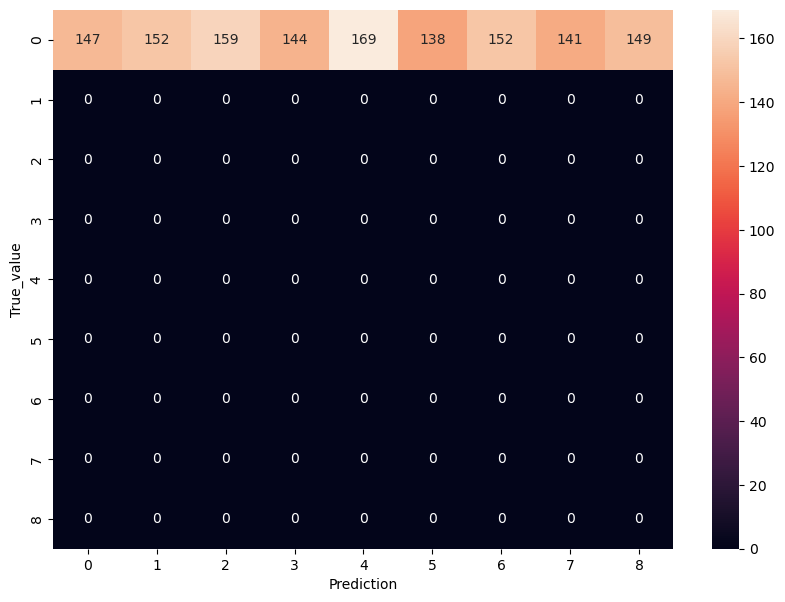

In [48]:
#Confusion Matrix - verify accuracy of each class
import seaborn as sns
cm = tf.math.confusion_matrix(labels = y_test_index, predictions = prediction_ANN_rounded)
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True_value')